In [1]:
%%time
import numpy as np
import pandas as pd
import librosa
import librosa.display
import wave
from scipy.io import wavfile
from glob import glob
import os
import random
import matplotlib
import matplotlib.pyplot as plt
import IPython.display as ipd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split

import librosa
import numpy as np
import scipy
import keras
from keras import losses, models, optimizers
from keras.activations import relu, softmax,sigmoid
from keras import regularizers
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, SeparableConv1D,
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('ggplot')
print("Package Done!")


D:\Applications\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Package Done!
Wall time: 1min 24s


In [2]:
meta_data = pd.read_csv("E:/Urban Sound/UrbanSound8k.csv")

In [3]:
meta_data.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


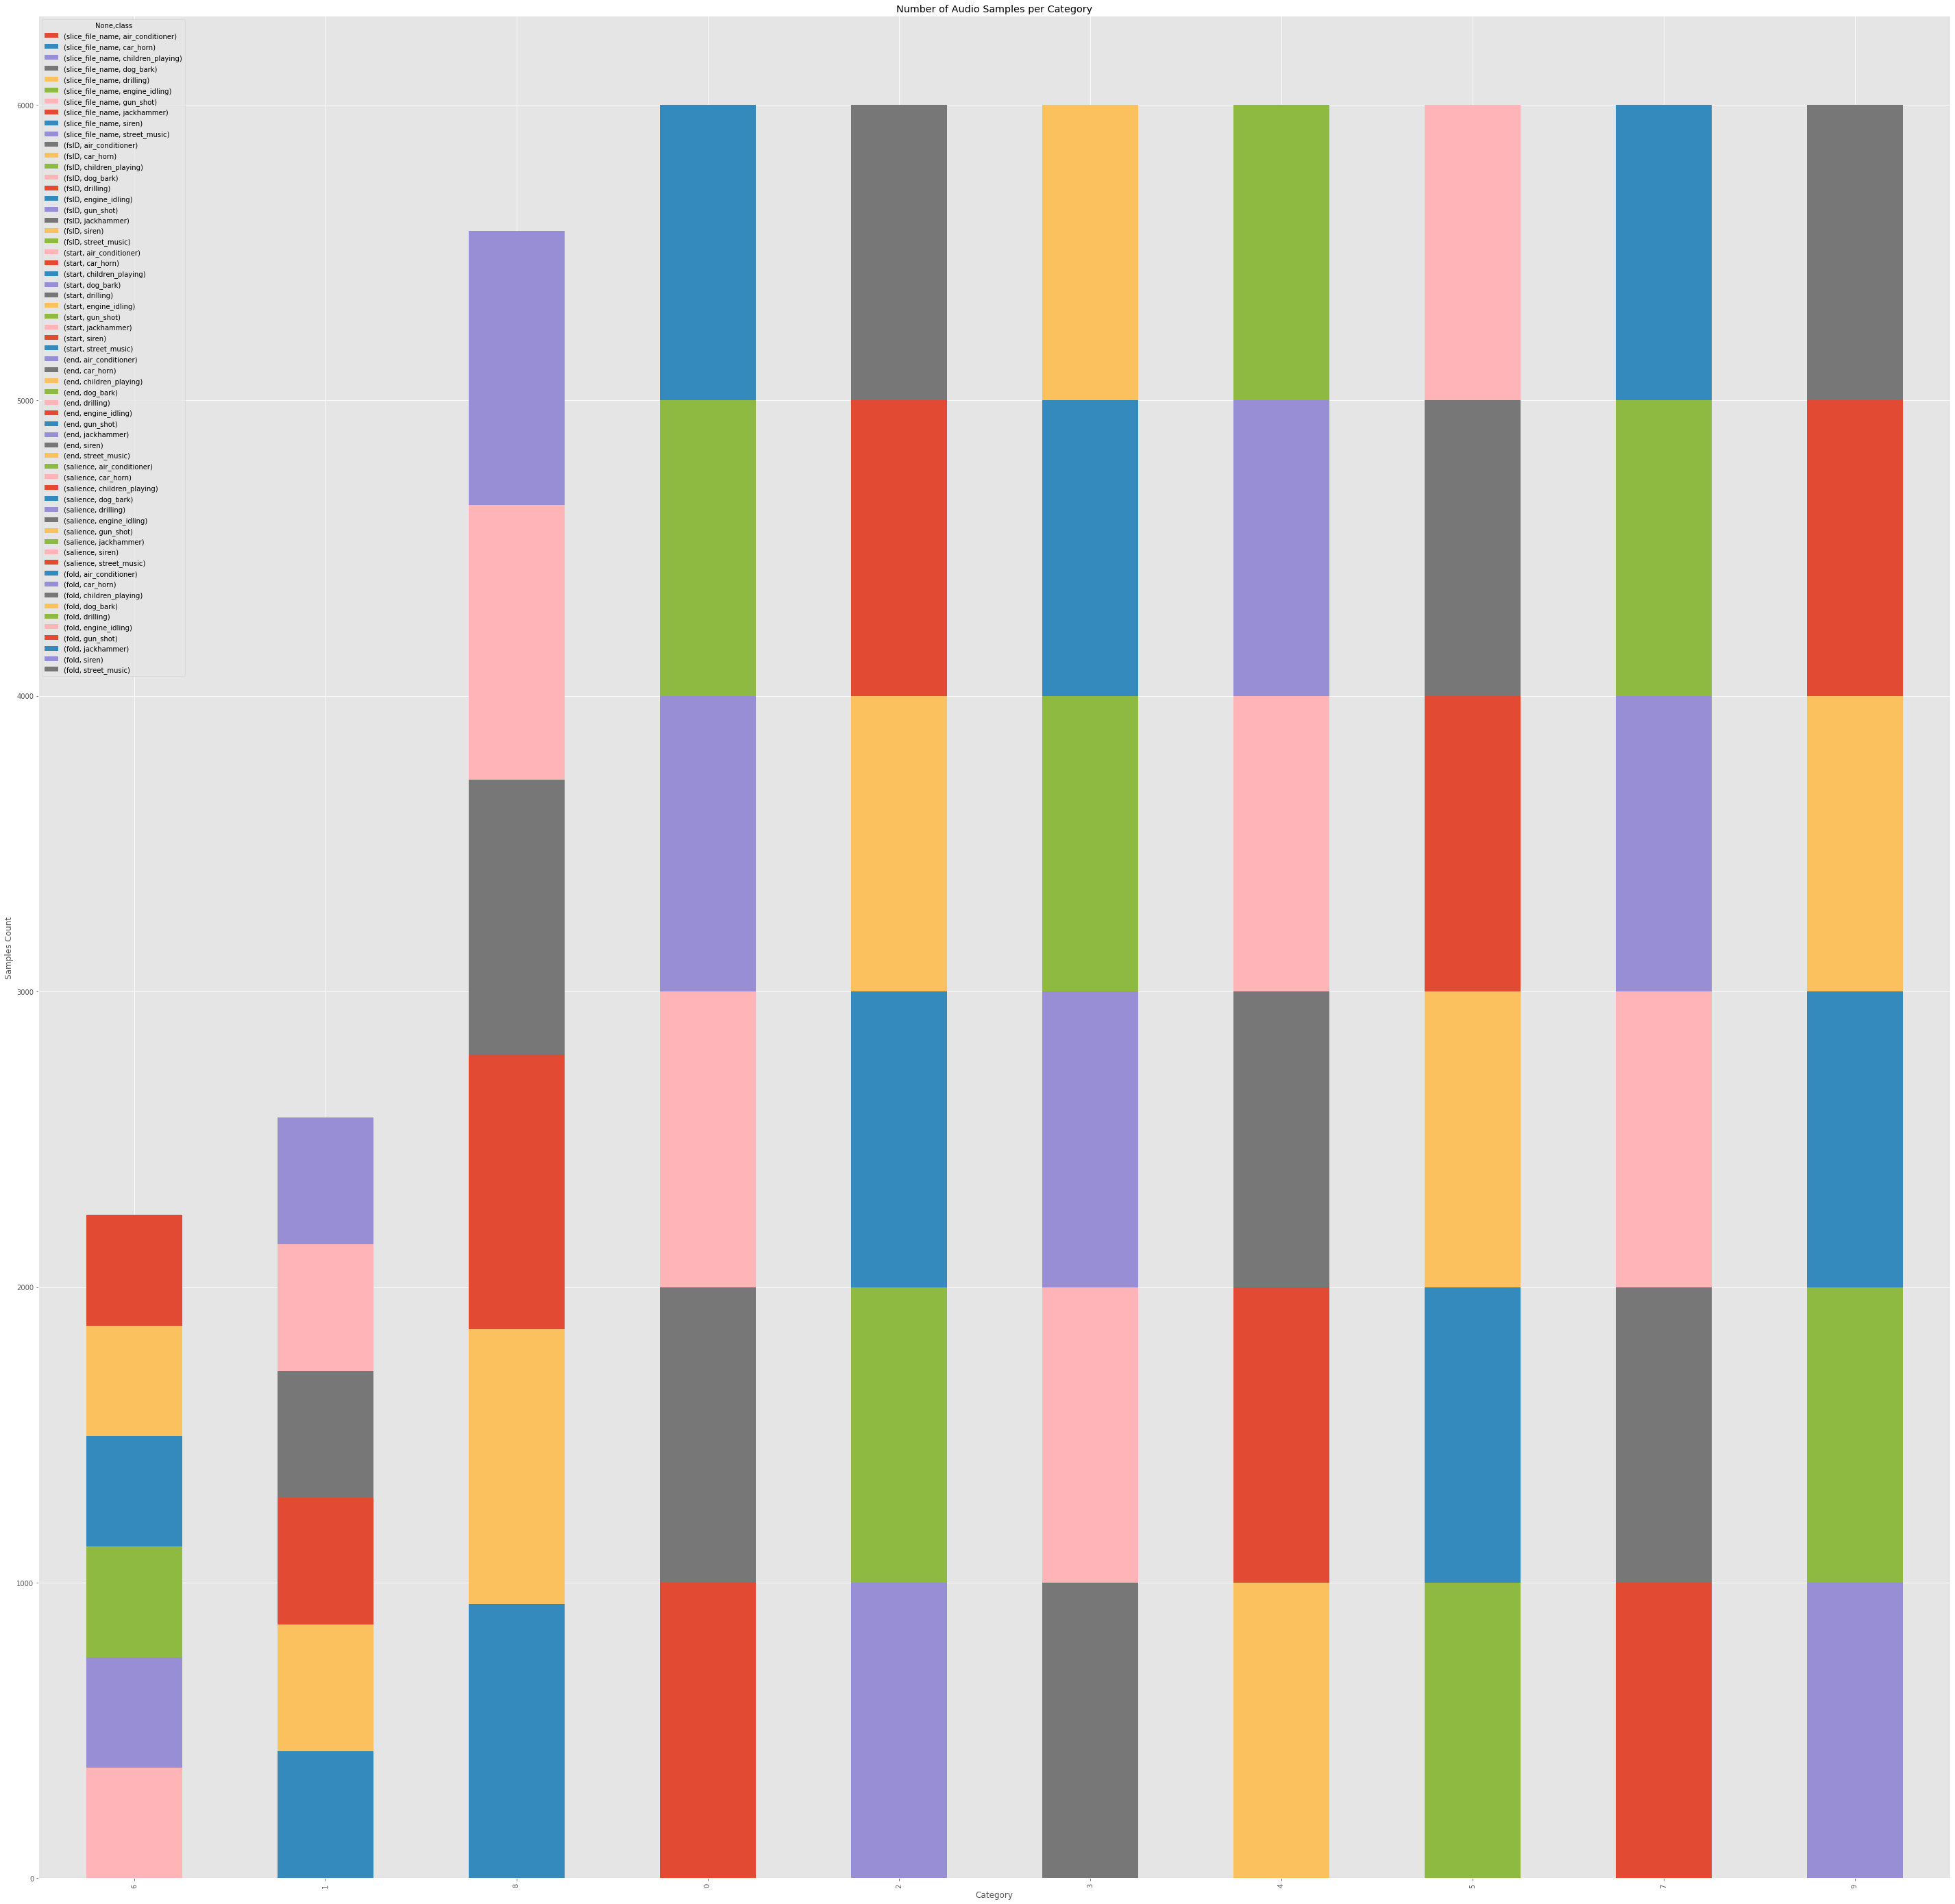

In [4]:
# visualize data distribution by category
category_group = meta_data.groupby(['classID','class']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(50,50))
plot.set_xlabel("Category")
plot.set_ylabel("Samples Count");


In [6]:
print('Min samples per category = ', min(meta_data.classID.value_counts()))
print('Max samples per category = ', max(meta_data.classID.value_counts()))

Min samples per category =  374
Max samples per category =  1000


In [8]:
meta_data.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [9]:
meta_data['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

In [10]:
len(meta_data['class'].unique())

10

In [11]:
filt = (meta_data['class'] =='dog_bark') | (meta_data['class'] =='children_playing')

In [12]:
df = meta_data[filt]

In [13]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [14]:
df['class'].unique()

array(['dog_bark', 'children_playing'], dtype=object)

In [15]:
df.groupby(['class']).count()

,slice_file_name,fsID,start,end,salience,fold,classID
class,,,,,,,
children_playing,1000,1000,1000,1000,1000,1000,1000
dog_bark,1000,1000,1000,1000,1000,1000,1000


In [16]:
df[['slice_file_name','fsID' ,'start', 'end','salience','fold','classID','class']].to_csv("df.csv", index=False)

In [17]:
train = pd.read_csv("df.csv")
train.head(100)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
95,109703-2-0-134.wav,109703,67.0,71.000000,2,2,2,children_playing
96,109703-2-0-14.wav,109703,7.0,11.000000,2,2,2,children_playing
97,109703-2-0-153.wav,109703,76.5,80.500000,2,2,2,children_playing
98,109703-2-0-29.wav,109703,14.5,18.500000,2,2,2,children_playing


In [18]:
###Audo Directory
Data_dir = "E:/Urban Sound/Data/"

In [19]:
os.listdir(Data_dir)

['fold1',
 'fold10',
 'fold2',
 'fold3',
 'fold4',
 'fold5',
 'fold6',
 'fold7',
 'fold8',
 'fold9']

In [20]:
len(os.listdir(Data_dir + 'fold10'))

837

In [31]:
%%time
feature = []
label = []

def load_data(row):
    # Function to load files and extract features
    input_length = 3 * 44100
    for i in range(2000):
        file_name = Data_dir + '/fold' + str(train['fold'][i]) + '/' + train["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        audio = librosa.util.fix_length(X,input_length)
        # We extract mfcc feature from data      
        feature.append(audio)
        if (train["classID"][i] == 2):
            label.append(0)
        elif (train["classID"][i] == 3):
            label.append(1)
    return [feature, label]

Wall time: 2.04 ms


In [32]:
%%time
temp = load_data(train)

Wall time: 4min 33s


In [33]:
%%time
temp

Wall time: 0 ns


[[array([-0.00331679, -0.00511129, -0.00463269, ...,  0.        ,
          0.        ,  0.        ], dtype=float32),
  array([0.00263754, 0.00368522, 0.00232162, ..., 0.        , 0.        ,
         0.        ], dtype=float32),
  array([-0.00258304, -0.0031084 , -0.00157768, ...,  0.        ,
          0.        ,  0.        ], dtype=float32),
  array([ 0.00016092, -0.00024385, -0.00135355, ...,  0.        ,
          0.        ,  0.        ], dtype=float32),
  array([0.0012375 , 0.00430785, 0.00621418, ..., 0.        , 0.        ,
         0.        ], dtype=float32),
  array([0.00416184, 0.0079709 , 0.00715376, ..., 0.        , 0.        ,
         0.        ], dtype=float32),
  array([-0.00123758, -0.00275501, -0.00226455, ...,  0.        ,
          0.        ,  0.        ], dtype=float32),
  array([0.00321306, 0.00472109, 0.00362435, ..., 0.        , 0.        ,
         0.        ], dtype=float32),
  array([-0.0012449 , -0.00150277, -0.00021402, ...,  0.        ,
          0.  

In [34]:
%%time
X_data = np.array(temp[0])
Y_data = np.array(temp[1])

Wall time: 4.89 s


In [35]:
X_data.shape

(2000, 132300)

In [36]:
len(X_data)

2000

In [37]:
print(f"X_data Shape: {X_data.shape}")
print(f"X_data dim: {X_data.ndim}")
print(f"Y_data Shape: {Y_data.shape}")
print(f"Y_data dim: {Y_data.ndim}")

X_data Shape: (2000, 132300)
X_data dim: 2
Y_data Shape: (2000,)
Y_data dim: 1


In [54]:
len(X_data[2])

132300

In [67]:
X_data = X_data.reshape(2000,132300,1)
X_data.shape

(2000, 132300, 1)

In [68]:
%%time
seed = 1000
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_data,Y_data,train_size=0.75,random_state = seed,shuffle = True)
X_TEST, X_VAL, Y_TEST, Y_VAL = train_test_split(X_TEST,Y_TEST,train_size=0.50,random_state = seed,shuffle = True)

Wall time: 1min 3s


In [69]:
print(f"Train Data Shape: {X_TRAIN.shape}\nTrain Label Shape: {Y_TRAIN.shape}\n")
print(f"Validation Data Shape: {X_VAL.shape}\nValidation Label Shape: {Y_VAL.shape}\n")
print(f"Test Data Shape: {X_TEST.shape}\nTrain Label Shape: {Y_TEST.shape}\n")
print(f"Total Train and Validation Data: {len(X_TRAIN) + len(X_VAL)}")
print(f"Total Train, Validation and Test  Data: {len(X_TRAIN) + len(X_VAL) + len(X_TEST)} \n")

Train Data Shape: (1500, 132300, 1)
Train Label Shape: (1500,)

Validation Data Shape: (250, 132300, 1)
Validation Label Shape: (250,)

Test Data Shape: (250, 132300, 1)
Train Label Shape: (250,)

Total Train and Validation Data: 1750
Total Train, Validation and Test  Data: 2000 



In [70]:
NB_CLASS =len (train['class'].unique())
NB_CLASS

2

In [71]:
print(Y_TRAIN[0:150])
print(Y_TRAIN.shape)

[1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1
 1 0 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0
 1 1 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0
 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0
 0 1]
(1500,)


In [72]:
Y_TRAIN = np.array(keras.utils.to_categorical(Y_TRAIN, NB_CLASS))
print(Y_TRAIN)
print(Y_TRAIN.shape)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
(1500, 2)


In [73]:
print(Y_TEST)
print(Y_TEST.shape)

[0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1
 0 0 1 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1
 0 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1
 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1
 1 1 0 1 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1
 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1
 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
(250,)


In [74]:
Y_TEST = np.array(keras.utils.to_categorical(Y_TEST, NB_CLASS))
print(Y_TEST)
print(Y_TEST.shape)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 

In [75]:
print(Y_VAL)
print(Y_VAL.shape)

[0 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 1 1
 1 0 1 0 1 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0
 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0
 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 0 1 1
 0 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 1 0 0 0
 1 0 1 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1]
(250,)


In [76]:
Y_VAL = np.array(keras.utils.to_categorical(Y_VAL, NB_CLASS))
print(Y_VAL)
print(Y_VAL.shape)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

In [77]:
print ("label shape: ", Y_data.shape)
print ("data size of the array: : %s" % Y_data.size)
print ("length of one array element in bytes: ", Y_data.itemsize)
print ("total bytes consumed by the elements of the array: ",Y_data.nbytes)
print (Y_data[1])
print ("")
print ("audio data shape: ", X_data.shape)
print ("data size of the array: : %s" % X_data.size)
print ("length of one array element in bytes: ", X_data.itemsize)
print ("total bytes consumed by the elements of the array: ", X_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", X_TRAIN.shape)
print ("training label shape: ", Y_TRAIN.shape)
print ("")
print ("validation data shape: ", X_VAL.shape)
print ("validation label shape: ", Y_VAL.shape)
print ("")
print ("test data shape: ", X_TEST.shape)
print ("test label shape: ", Y_TEST.shape)
print ("")

label shape:  (2000,)
data size of the array: : 2000
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  8000
0

audio data shape:  (2000, 132300, 1)
data size of the array: : 264600000
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  1058400000

training data shape:  (1500, 132300, 1)
training label shape:  (1500, 2)

validation data shape:  (250, 132300, 1)
validation label shape:  (250, 2)

test data shape:  (250, 132300, 1)
test label shape:  (250, 2)



In [78]:
input_length = 132300

inp = Input(shape=(132300,1))
inp.shape

TensorShape([None, 132300, 1])

In [79]:
print( " Raw Audio Model Using CNN")

x = Convolution1D(16, 6, activation=relu, padding="valid") (inp)
x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
x = MaxPool1D(16)(x)
x = Dropout(rate=0.2)(x)

#x = Convolution1D(32, 9, activation=relu, padding="valid")(x)
x = Convolution1D(32, 9, activation=relu, padding="valid")(x)
x = MaxPool1D(16)(x)
x = Dropout(rate=0.2)(x)

#x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
#x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
#x = MaxPool1D(4)(x)
#x = Dropout(rate=0.1)(x)

x = Convolution1D(64, 3, activation=relu, padding="valid")(x)
x = Convolution1D(64, 3, activation=relu, padding="valid")(x)
x = MaxPool1D(4)(x)
x = Dropout(rate=0.2)(x)

x = Convolution1D(128, 3, activation=relu, padding="valid")(x)
x = Convolution1D(128, 3, activation=relu, padding="valid")(x)
x = GlobalMaxPool1D()(x)
x = Dropout(rate=0.2)(x)

#model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
#model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),activation='relu'))
x = Dense(16,kernel_regularizer=regularizers.l2(0.001),activation=relu) (x)
x = Dense(16,kernel_regularizer=regularizers.l2(0.001),activation=relu) (x)
x = Dense(64, activation=relu)(x)
x = Dense(128, activation=relu)(x)
out = Dense(NB_CLASS, activation=sigmoid)(x)


model = models.Model(inputs=inp, outputs=out)
opt = optimizers.Adam(0.003)

model.compile(optimizer=opt, loss=losses.binary_crossentropy, metrics=['acc'])

model.summary()


 Raw Audio Model Using CNN
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 132300, 1)         0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 132295, 16)        112       
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 132287, 16)        2320      
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 8267, 16)          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8267, 16)          0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 8259, 32)          4640      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (No

In [80]:
%%time
# saved model checkpoint file
best_CNN_model_file="./best_CNN_model_trained.hdf5"
#train_model_file=file_path+"/checkpoints/weights.best_{epoch:02d}-{loss:.2f}.hdf5"
MAX_PATIENT=12
MAX_EPOCHS=40
MAX_BATCH=10

# callbacks
# removed EarlyStopping(patience=MAX_PATIENT)
#callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          #ModelCheckpoint(filepath=best_CNN_model_file, monitor='loss', verbose=1, save_best_only=True)]

print ("training started..... please wait.")
# training
history=model.fit(X_TRAIN, Y_TRAIN, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=1,
                  validation_data=(X_VAL, Y_VAL),
                  #callbacks=callback
                 ) 
                 

print ("training finised!")


training started..... please wait.
Train on 1500 samples, validate on 250 samples
Epoch 1/40
1500/1500 [==============================] - ETA: 58:16 - loss: 0.7375 - acc: 0.40 - ETA: 33:31 - loss: 0.7360 - acc: 0.45 - ETA: 23:52 - loss: 0.7290 - acc: 0.50 - ETA: 19:02 - loss: 0.7252 - acc: 0.50 - ETA: 15:54 - loss: 0.7256 - acc: 0.52 - ETA: 13:52 - loss: 0.6957 - acc: 0.56 - ETA: 12:22 - loss: 0.7186 - acc: 0.54 - ETA: 11:11 - loss: 0.7335 - acc: 0.53 - ETA: 10:18 - loss: 0.7393 - acc: 0.52 - ETA: 9:34 - loss: 0.7371 - acc: 0.5000 - ETA: 8:59 - loss: 0.7352 - acc: 0.490 - ETA: 8:34 - loss: 0.7336 - acc: 0.500 - ETA: 8:05 - loss: 0.7323 - acc: 0.523 - ETA: 7:40 - loss: 0.7315 - acc: 0.532 - ETA: 7:28 - loss: 0.7304 - acc: 0.546 - ETA: 7:11 - loss: 0.7294 - acc: 0.559 - ETA: 6:55 - loss: 0.7285 - acc: 0.573 - ETA: 6:45 - loss: 0.7281 - acc: 0.572 - ETA: 6:33 - loss: 0.7273 - acc: 0.584 - ETA: 6:20 - loss: 0.7263 - acc: 0.600 - ETA: 6:08 - loss: 0.7258 - acc: 0.595 - ETA: 5:57 - loss: 0.7

1500/1500 [==============================] - ETA: 3:35 - loss: 0.2818 - acc: 0.900 - ETA: 3:25 - loss: 0.3520 - acc: 0.900 - ETA: 3:22 - loss: 0.4586 - acc: 0.800 - ETA: 3:20 - loss: 0.4960 - acc: 0.750 - ETA: 3:18 - loss: 0.4718 - acc: 0.780 - ETA: 3:16 - loss: 0.4757 - acc: 0.783 - ETA: 3:14 - loss: 0.4722 - acc: 0.785 - ETA: 3:13 - loss: 0.4693 - acc: 0.800 - ETA: 3:11 - loss: 0.5202 - acc: 0.800 - ETA: 3:11 - loss: 0.5061 - acc: 0.810 - ETA: 3:12 - loss: 0.4938 - acc: 0.818 - ETA: 3:14 - loss: 0.4768 - acc: 0.825 - ETA: 3:17 - loss: 0.5041 - acc: 0.800 - ETA: 3:17 - loss: 0.5244 - acc: 0.778 - ETA: 3:18 - loss: 0.5274 - acc: 0.773 - ETA: 3:19 - loss: 0.5095 - acc: 0.787 - ETA: 3:19 - loss: 0.5116 - acc: 0.782 - ETA: 3:17 - loss: 0.5298 - acc: 0.766 - ETA: 3:16 - loss: 0.5340 - acc: 0.768 - ETA: 3:13 - loss: 0.5335 - acc: 0.770 - ETA: 3:11 - loss: 0.5256 - acc: 0.781 - ETA: 3:09 - loss: 0.5175 - acc: 0.786 - ETA: 3:07 - loss: 0.5125 - acc: 0.791 - ETA: 3:06 - loss: 0.5177 - acc: 0.7

1500/1500 [==============================] - ETA: 3:22 - loss: 0.4931 - acc: 0.800 - ETA: 3:24 - loss: 0.3930 - acc: 0.850 - ETA: 3:21 - loss: 0.4842 - acc: 0.733 - ETA: 3:19 - loss: 0.5063 - acc: 0.737 - ETA: 3:17 - loss: 0.4874 - acc: 0.770 - ETA: 3:16 - loss: 0.4930 - acc: 0.775 - ETA: 3:15 - loss: 0.5027 - acc: 0.771 - ETA: 3:13 - loss: 0.4890 - acc: 0.787 - ETA: 3:12 - loss: 0.4894 - acc: 0.800 - ETA: 3:11 - loss: 0.4903 - acc: 0.800 - ETA: 3:10 - loss: 0.4769 - acc: 0.818 - ETA: 3:09 - loss: 0.5207 - acc: 0.783 - ETA: 3:08 - loss: 0.5339 - acc: 0.776 - ETA: 3:08 - loss: 0.5490 - acc: 0.764 - ETA: 3:08 - loss: 0.5519 - acc: 0.753 - ETA: 3:06 - loss: 0.5416 - acc: 0.762 - ETA: 3:05 - loss: 0.5357 - acc: 0.770 - ETA: 3:03 - loss: 0.5426 - acc: 0.761 - ETA: 3:02 - loss: 0.5626 - acc: 0.763 - ETA: 3:01 - loss: 0.5632 - acc: 0.760 - ETA: 3:00 - loss: 0.5554 - acc: 0.761 - ETA: 2:58 - loss: 0.5594 - acc: 0.754 - ETA: 2:57 - loss: 0.5583 - acc: 0.752 - ETA: 2:55 - loss: 0.5584 - acc: 0.7

1500/1500 [==============================] - ETA: 3:19 - loss: 0.4566 - acc: 0.800 - ETA: 3:16 - loss: 0.3835 - acc: 0.850 - ETA: 3:16 - loss: 0.3476 - acc: 0.900 - ETA: 3:14 - loss: 0.3672 - acc: 0.875 - ETA: 3:12 - loss: 0.3890 - acc: 0.840 - ETA: 3:11 - loss: 0.4025 - acc: 0.833 - ETA: 3:09 - loss: 0.4151 - acc: 0.814 - ETA: 3:07 - loss: 0.4591 - acc: 0.800 - ETA: 3:07 - loss: 0.4332 - acc: 0.822 - ETA: 3:05 - loss: 0.4358 - acc: 0.810 - ETA: 3:04 - loss: 0.4068 - acc: 0.827 - ETA: 3:03 - loss: 0.3854 - acc: 0.841 - ETA: 3:03 - loss: 0.3818 - acc: 0.846 - ETA: 3:03 - loss: 0.4012 - acc: 0.835 - ETA: 3:02 - loss: 0.4131 - acc: 0.820 - ETA: 3:00 - loss: 0.4067 - acc: 0.825 - ETA: 2:59 - loss: 0.4014 - acc: 0.835 - ETA: 2:57 - loss: 0.4067 - acc: 0.833 - ETA: 2:56 - loss: 0.4007 - acc: 0.842 - ETA: 2:54 - loss: 0.4004 - acc: 0.840 - ETA: 2:53 - loss: 0.4038 - acc: 0.838 - ETA: 2:51 - loss: 0.3949 - acc: 0.845 - ETA: 2:50 - loss: 0.4112 - acc: 0.830 - ETA: 2:49 - loss: 0.4114 - acc: 0.8

1500/1500 [==============================] - ETA: 3:23 - loss: 0.4901 - acc: 0.700 - ETA: 3:19 - loss: 0.4247 - acc: 0.750 - ETA: 3:16 - loss: 0.4695 - acc: 0.766 - ETA: 3:14 - loss: 0.6263 - acc: 0.675 - ETA: 3:12 - loss: 0.6021 - acc: 0.700 - ETA: 3:11 - loss: 0.5698 - acc: 0.716 - ETA: 3:10 - loss: 0.5485 - acc: 0.728 - ETA: 3:09 - loss: 0.5493 - acc: 0.725 - ETA: 3:07 - loss: 0.5479 - acc: 0.733 - ETA: 3:06 - loss: 0.5400 - acc: 0.740 - ETA: 3:05 - loss: 0.5155 - acc: 0.754 - ETA: 3:04 - loss: 0.5070 - acc: 0.758 - ETA: 3:03 - loss: 0.5000 - acc: 0.769 - ETA: 3:01 - loss: 0.4981 - acc: 0.771 - ETA: 3:00 - loss: 0.5002 - acc: 0.773 - ETA: 2:59 - loss: 0.5079 - acc: 0.765 - ETA: 2:58 - loss: 0.5099 - acc: 0.761 - ETA: 2:56 - loss: 0.5024 - acc: 0.769 - ETA: 2:55 - loss: 0.4904 - acc: 0.781 - ETA: 2:53 - loss: 0.4903 - acc: 0.777 - ETA: 2:53 - loss: 0.4835 - acc: 0.783 - ETA: 2:52 - loss: 0.4849 - acc: 0.784 - ETA: 2:50 - loss: 0.4777 - acc: 0.791 - ETA: 2:49 - loss: 0.4810 - acc: 0.7

1500/1500 [==============================] - ETA: 3:19 - loss: 0.3719 - acc: 0.800 - ETA: 3:19 - loss: 0.3816 - acc: 0.800 - ETA: 3:17 - loss: 0.3436 - acc: 0.866 - ETA: 3:14 - loss: 0.3549 - acc: 0.875 - ETA: 3:13 - loss: 0.3541 - acc: 0.880 - ETA: 3:12 - loss: 0.3897 - acc: 0.850 - ETA: 3:11 - loss: 0.3598 - acc: 0.871 - ETA: 3:10 - loss: 0.3957 - acc: 0.837 - ETA: 3:09 - loss: 0.3898 - acc: 0.833 - ETA: 3:07 - loss: 0.3947 - acc: 0.830 - ETA: 3:06 - loss: 0.3900 - acc: 0.836 - ETA: 3:04 - loss: 0.3836 - acc: 0.841 - ETA: 3:03 - loss: 0.3720 - acc: 0.853 - ETA: 3:03 - loss: 0.3697 - acc: 0.850 - ETA: 3:03 - loss: 0.3645 - acc: 0.846 - ETA: 3:02 - loss: 0.3665 - acc: 0.843 - ETA: 3:00 - loss: 0.3632 - acc: 0.841 - ETA: 2:58 - loss: 0.3597 - acc: 0.844 - ETA: 2:57 - loss: 0.3812 - acc: 0.831 - ETA: 2:55 - loss: 0.3892 - acc: 0.825 - ETA: 2:54 - loss: 0.4015 - acc: 0.819 - ETA: 2:52 - loss: 0.4000 - acc: 0.822 - ETA: 2:51 - loss: 0.3964 - acc: 0.826 - ETA: 2:50 - loss: 0.3895 - acc: 0.8

1500/1500 [==============================] - ETA: 3:30 - loss: 0.6572 - acc: 0.600 - ETA: 3:33 - loss: 0.5774 - acc: 0.700 - ETA: 3:33 - loss: 0.5589 - acc: 0.733 - ETA: 3:28 - loss: 0.5633 - acc: 0.750 - ETA: 3:24 - loss: 0.5975 - acc: 0.700 - ETA: 3:24 - loss: 0.6153 - acc: 0.683 - ETA: 3:21 - loss: 0.5867 - acc: 0.714 - ETA: 3:18 - loss: 0.5395 - acc: 0.750 - ETA: 3:16 - loss: 0.5188 - acc: 0.766 - ETA: 3:13 - loss: 0.4918 - acc: 0.790 - ETA: 3:12 - loss: 0.4790 - acc: 0.800 - ETA: 3:10 - loss: 0.4819 - acc: 0.791 - ETA: 3:10 - loss: 0.4691 - acc: 0.800 - ETA: 3:08 - loss: 0.4646 - acc: 0.807 - ETA: 3:07 - loss: 0.4596 - acc: 0.806 - ETA: 3:06 - loss: 0.4519 - acc: 0.812 - ETA: 3:06 - loss: 0.4443 - acc: 0.817 - ETA: 3:04 - loss: 0.4587 - acc: 0.816 - ETA: 3:04 - loss: 0.4639 - acc: 0.810 - ETA: 3:03 - loss: 0.4708 - acc: 0.800 - ETA: 3:02 - loss: 0.4748 - acc: 0.795 - ETA: 3:00 - loss: 0.4671 - acc: 0.800 - ETA: 3:00 - loss: 0.4774 - acc: 0.791 - ETA: 2:59 - loss: 0.4784 - acc: 0.7

1500/1500 [==============================] - ETA: 3:13 - loss: 0.4156 - acc: 0.900 - ETA: 3:13 - loss: 0.3277 - acc: 0.950 - ETA: 3:15 - loss: 0.3575 - acc: 0.933 - ETA: 3:14 - loss: 0.3331 - acc: 0.925 - ETA: 3:12 - loss: 0.3809 - acc: 0.900 - ETA: 3:11 - loss: 0.3638 - acc: 0.900 - ETA: 3:09 - loss: 0.3774 - acc: 0.885 - ETA: 3:08 - loss: 0.3746 - acc: 0.875 - ETA: 3:07 - loss: 0.3614 - acc: 0.888 - ETA: 3:06 - loss: 0.3498 - acc: 0.890 - ETA: 3:04 - loss: 0.3482 - acc: 0.890 - ETA: 3:03 - loss: 0.3453 - acc: 0.891 - ETA: 3:01 - loss: 0.3495 - acc: 0.884 - ETA: 3:00 - loss: 0.3710 - acc: 0.871 - ETA: 2:59 - loss: 0.3640 - acc: 0.880 - ETA: 2:58 - loss: 0.3640 - acc: 0.875 - ETA: 2:56 - loss: 0.3556 - acc: 0.882 - ETA: 2:55 - loss: 0.3663 - acc: 0.872 - ETA: 2:54 - loss: 0.3685 - acc: 0.873 - ETA: 2:52 - loss: 0.3698 - acc: 0.870 - ETA: 2:51 - loss: 0.3831 - acc: 0.857 - ETA: 2:50 - loss: 0.3807 - acc: 0.859 - ETA: 2:48 - loss: 0.3805 - acc: 0.856 - ETA: 2:47 - loss: 0.3922 - acc: 0.8

1500/1500 [==============================] - ETA: 3:17 - loss: 0.5088 - acc: 0.800 - ETA: 3:18 - loss: 0.3308 - acc: 0.900 - ETA: 3:17 - loss: 0.3225 - acc: 0.900 - ETA: 3:15 - loss: 0.3141 - acc: 0.900 - ETA: 3:14 - loss: 0.3084 - acc: 0.880 - ETA: 3:13 - loss: 0.3632 - acc: 0.833 - ETA: 3:11 - loss: 0.3788 - acc: 0.828 - ETA: 3:10 - loss: 0.3620 - acc: 0.850 - ETA: 3:09 - loss: 0.3767 - acc: 0.833 - ETA: 3:07 - loss: 0.3641 - acc: 0.830 - ETA: 3:06 - loss: 0.3681 - acc: 0.836 - ETA: 3:05 - loss: 0.3547 - acc: 0.850 - ETA: 3:03 - loss: 0.3636 - acc: 0.846 - ETA: 3:02 - loss: 0.3774 - acc: 0.835 - ETA: 3:01 - loss: 0.3721 - acc: 0.840 - ETA: 3:00 - loss: 0.3662 - acc: 0.843 - ETA: 3:00 - loss: 0.3624 - acc: 0.847 - ETA: 2:59 - loss: 0.3625 - acc: 0.850 - ETA: 2:58 - loss: 0.3668 - acc: 0.852 - ETA: 2:56 - loss: 0.3652 - acc: 0.855 - ETA: 2:55 - loss: 0.3650 - acc: 0.852 - ETA: 2:54 - loss: 0.3756 - acc: 0.845 - ETA: 2:52 - loss: 0.3779 - acc: 0.843 - ETA: 2:51 - loss: 0.3717 - acc: 0.8

1500/1500 [==============================] - ETA: 3:20 - loss: 0.4310 - acc: 0.800 - ETA: 3:18 - loss: 0.3409 - acc: 0.850 - ETA: 3:33 - loss: 0.3813 - acc: 0.833 - ETA: 3:35 - loss: 0.4056 - acc: 0.800 - ETA: 3:43 - loss: 0.4626 - acc: 0.760 - ETA: 3:39 - loss: 0.4932 - acc: 0.750 - ETA: 3:34 - loss: 0.4527 - acc: 0.785 - ETA: 3:30 - loss: 0.4298 - acc: 0.800 - ETA: 3:27 - loss: 0.4375 - acc: 0.800 - ETA: 3:25 - loss: 0.4344 - acc: 0.780 - ETA: 3:23 - loss: 0.4228 - acc: 0.790 - ETA: 3:22 - loss: 0.4098 - acc: 0.800 - ETA: 3:21 - loss: 0.4020 - acc: 0.807 - ETA: 3:19 - loss: 0.3882 - acc: 0.814 - ETA: 3:18 - loss: 0.3930 - acc: 0.806 - ETA: 3:16 - loss: 0.3835 - acc: 0.812 - ETA: 3:14 - loss: 0.3664 - acc: 0.823 - ETA: 3:12 - loss: 0.3798 - acc: 0.816 - ETA: 3:12 - loss: 0.3698 - acc: 0.826 - ETA: 3:10 - loss: 0.3663 - acc: 0.830 - ETA: 3:09 - loss: 0.3754 - acc: 0.828 - ETA: 3:07 - loss: 0.3813 - acc: 0.831 - ETA: 3:05 - loss: 0.3797 - acc: 0.830 - ETA: 3:03 - loss: 0.3799 - acc: 0.8

1500/1500 [==============================] - ETA: 3:29 - loss: 0.6911 - acc: 0.700 - ETA: 3:25 - loss: 0.4054 - acc: 0.850 - ETA: 3:24 - loss: 0.3651 - acc: 0.866 - ETA: 3:24 - loss: 0.3199 - acc: 0.900 - ETA: 3:21 - loss: 0.3090 - acc: 0.900 - ETA: 3:19 - loss: 0.3036 - acc: 0.900 - ETA: 3:17 - loss: 0.3161 - acc: 0.885 - ETA: 3:15 - loss: 0.3719 - acc: 0.850 - ETA: 3:13 - loss: 0.3568 - acc: 0.866 - ETA: 3:12 - loss: 0.3726 - acc: 0.860 - ETA: 3:10 - loss: 0.3736 - acc: 0.854 - ETA: 3:09 - loss: 0.4181 - acc: 0.841 - ETA: 3:07 - loss: 0.4467 - acc: 0.823 - ETA: 3:06 - loss: 0.4400 - acc: 0.821 - ETA: 3:04 - loss: 0.4300 - acc: 0.826 - ETA: 3:03 - loss: 0.4227 - acc: 0.831 - ETA: 3:02 - loss: 0.4313 - acc: 0.823 - ETA: 3:00 - loss: 0.4333 - acc: 0.822 - ETA: 2:59 - loss: 0.4476 - acc: 0.815 - ETA: 2:57 - loss: 0.4387 - acc: 0.815 - ETA: 2:56 - loss: 0.4322 - acc: 0.819 - ETA: 2:54 - loss: 0.4375 - acc: 0.818 - ETA: 2:53 - loss: 0.4282 - acc: 0.823 - ETA: 2:51 - loss: 0.4224 - acc: 0.8

1500/1500 [==============================] - ETA: 3:23 - loss: 0.4677 - acc: 0.900 - ETA: 3:21 - loss: 0.3775 - acc: 0.900 - ETA: 3:19 - loss: 0.3607 - acc: 0.900 - ETA: 3:17 - loss: 0.3451 - acc: 0.900 - ETA: 3:15 - loss: 0.4111 - acc: 0.840 - ETA: 3:13 - loss: 0.3971 - acc: 0.850 - ETA: 3:12 - loss: 0.3764 - acc: 0.857 - ETA: 3:10 - loss: 0.4038 - acc: 0.837 - ETA: 3:09 - loss: 0.4259 - acc: 0.822 - ETA: 3:08 - loss: 0.3967 - acc: 0.840 - ETA: 3:06 - loss: 0.3933 - acc: 0.836 - ETA: 3:05 - loss: 0.3999 - acc: 0.833 - ETA: 3:04 - loss: 0.4177 - acc: 0.823 - ETA: 3:03 - loss: 0.3960 - acc: 0.835 - ETA: 3:01 - loss: 0.3756 - acc: 0.846 - ETA: 3:00 - loss: 0.3615 - acc: 0.856 - ETA: 2:59 - loss: 0.3574 - acc: 0.858 - ETA: 2:57 - loss: 0.3515 - acc: 0.861 - ETA: 2:56 - loss: 0.3511 - acc: 0.863 - ETA: 2:54 - loss: 0.3406 - acc: 0.870 - ETA: 2:53 - loss: 0.3379 - acc: 0.871 - ETA: 2:52 - loss: 0.3273 - acc: 0.877 - ETA: 2:50 - loss: 0.3274 - acc: 0.878 - ETA: 2:49 - loss: 0.3247 - acc: 0.8

1500/1500 [==============================] - ETA: 3:23 - loss: 0.3447 - acc: 0.800 - ETA: 3:22 - loss: 0.4978 - acc: 0.700 - ETA: 3:22 - loss: 0.4364 - acc: 0.766 - ETA: 3:19 - loss: 0.3899 - acc: 0.825 - ETA: 3:17 - loss: 0.4323 - acc: 0.820 - ETA: 3:15 - loss: 0.4166 - acc: 0.833 - ETA: 3:14 - loss: 0.4249 - acc: 0.828 - ETA: 3:14 - loss: 0.4041 - acc: 0.837 - ETA: 3:13 - loss: 0.3743 - acc: 0.855 - ETA: 3:11 - loss: 0.3682 - acc: 0.860 - ETA: 3:10 - loss: 0.3716 - acc: 0.854 - ETA: 3:08 - loss: 0.3564 - acc: 0.866 - ETA: 3:07 - loss: 0.3483 - acc: 0.869 - ETA: 3:05 - loss: 0.3492 - acc: 0.864 - ETA: 3:04 - loss: 0.3470 - acc: 0.866 - ETA: 3:02 - loss: 0.3613 - acc: 0.856 - ETA: 3:01 - loss: 0.3643 - acc: 0.852 - ETA: 3:00 - loss: 0.3658 - acc: 0.850 - ETA: 2:58 - loss: 0.3664 - acc: 0.852 - ETA: 2:56 - loss: 0.3714 - acc: 0.845 - ETA: 2:55 - loss: 0.3609 - acc: 0.852 - ETA: 2:53 - loss: 0.3502 - acc: 0.859 - ETA: 2:52 - loss: 0.3433 - acc: 0.860 - ETA: 2:51 - loss: 0.3383 - acc: 0.8

1500/1500 [==============================] - ETA: 3:24 - loss: 0.4740 - acc: 0.800 - ETA: 3:19 - loss: 0.3865 - acc: 0.850 - ETA: 3:18 - loss: 0.2985 - acc: 0.900 - ETA: 3:16 - loss: 0.2588 - acc: 0.925 - ETA: 3:14 - loss: 0.2786 - acc: 0.900 - ETA: 3:13 - loss: 0.2717 - acc: 0.900 - ETA: 3:11 - loss: 0.2567 - acc: 0.914 - ETA: 3:10 - loss: 0.2714 - acc: 0.900 - ETA: 3:08 - loss: 0.2825 - acc: 0.888 - ETA: 3:07 - loss: 0.2829 - acc: 0.890 - ETA: 3:06 - loss: 0.2880 - acc: 0.881 - ETA: 3:05 - loss: 0.2729 - acc: 0.891 - ETA: 3:03 - loss: 0.3335 - acc: 0.853 - ETA: 3:02 - loss: 0.3423 - acc: 0.850 - ETA: 3:00 - loss: 0.3693 - acc: 0.833 - ETA: 2:59 - loss: 0.3936 - acc: 0.818 - ETA: 2:58 - loss: 0.4161 - acc: 0.805 - ETA: 2:56 - loss: 0.4062 - acc: 0.816 - ETA: 2:55 - loss: 0.4064 - acc: 0.815 - ETA: 2:54 - loss: 0.4059 - acc: 0.815 - ETA: 2:53 - loss: 0.4265 - acc: 0.809 - ETA: 2:51 - loss: 0.4222 - acc: 0.813 - ETA: 2:51 - loss: 0.4070 - acc: 0.821 - ETA: 2:50 - loss: 0.4060 - acc: 0.8

1500/1500 [==============================] - ETA: 3:18 - loss: 0.2869 - acc: 0.900 - ETA: 3:17 - loss: 0.2600 - acc: 0.900 - ETA: 3:15 - loss: 0.2501 - acc: 0.900 - ETA: 3:13 - loss: 0.2428 - acc: 0.900 - ETA: 3:12 - loss: 0.2631 - acc: 0.900 - ETA: 3:11 - loss: 0.2690 - acc: 0.900 - ETA: 3:10 - loss: 0.3419 - acc: 0.871 - ETA: 3:09 - loss: 0.3248 - acc: 0.875 - ETA: 3:08 - loss: 0.2977 - acc: 0.888 - ETA: 3:07 - loss: 0.2885 - acc: 0.890 - ETA: 3:07 - loss: 0.2946 - acc: 0.890 - ETA: 3:06 - loss: 0.2954 - acc: 0.891 - ETA: 3:05 - loss: 0.2820 - acc: 0.900 - ETA: 3:03 - loss: 0.2834 - acc: 0.900 - ETA: 3:02 - loss: 0.2834 - acc: 0.893 - ETA: 3:01 - loss: 0.2822 - acc: 0.893 - ETA: 2:59 - loss: 0.2856 - acc: 0.894 - ETA: 2:58 - loss: 0.2809 - acc: 0.900 - ETA: 2:57 - loss: 0.2804 - acc: 0.900 - ETA: 2:55 - loss: 0.2820 - acc: 0.900 - ETA: 2:54 - loss: 0.2863 - acc: 0.895 - ETA: 2:53 - loss: 0.3036 - acc: 0.886 - ETA: 2:52 - loss: 0.3072 - acc: 0.882 - ETA: 2:53 - loss: 0.3055 - acc: 0.8

1500/1500 [==============================] - ETA: 3:24 - loss: 0.1948 - acc: 1.000 - ETA: 3:20 - loss: 0.3038 - acc: 0.950 - ETA: 3:17 - loss: 0.2443 - acc: 0.966 - ETA: 3:15 - loss: 0.3486 - acc: 0.875 - ETA: 3:15 - loss: 0.3877 - acc: 0.840 - ETA: 3:14 - loss: 0.3383 - acc: 0.866 - ETA: 3:12 - loss: 0.3213 - acc: 0.885 - ETA: 3:11 - loss: 0.3076 - acc: 0.887 - ETA: 3:09 - loss: 0.3165 - acc: 0.888 - ETA: 3:07 - loss: 0.3741 - acc: 0.840 - ETA: 3:06 - loss: 0.3718 - acc: 0.845 - ETA: 3:04 - loss: 0.3772 - acc: 0.841 - ETA: 3:03 - loss: 0.3904 - acc: 0.830 - ETA: 3:01 - loss: 0.3905 - acc: 0.828 - ETA: 3:00 - loss: 0.4028 - acc: 0.826 - ETA: 2:59 - loss: 0.3853 - acc: 0.837 - ETA: 2:58 - loss: 0.3821 - acc: 0.841 - ETA: 2:58 - loss: 0.3683 - acc: 0.850 - ETA: 2:56 - loss: 0.3728 - acc: 0.847 - ETA: 2:55 - loss: 0.3677 - acc: 0.850 - ETA: 2:54 - loss: 0.3588 - acc: 0.852 - ETA: 2:53 - loss: 0.3542 - acc: 0.854 - ETA: 2:52 - loss: 0.3508 - acc: 0.856 - ETA: 2:50 - loss: 0.3619 - acc: 0.8

1500/1500 [==============================] - ETA: 3:24 - loss: 0.2544 - acc: 1.000 - ETA: 3:17 - loss: 0.2810 - acc: 0.950 - ETA: 3:17 - loss: 0.2986 - acc: 0.933 - ETA: 3:15 - loss: 0.3238 - acc: 0.900 - ETA: 3:13 - loss: 0.3428 - acc: 0.880 - ETA: 3:11 - loss: 0.3815 - acc: 0.850 - ETA: 3:10 - loss: 0.3698 - acc: 0.828 - ETA: 3:09 - loss: 0.3713 - acc: 0.825 - ETA: 3:07 - loss: 0.4078 - acc: 0.788 - ETA: 3:05 - loss: 0.3973 - acc: 0.800 - ETA: 3:04 - loss: 0.3940 - acc: 0.800 - ETA: 3:03 - loss: 0.4018 - acc: 0.791 - ETA: 3:01 - loss: 0.3933 - acc: 0.800 - ETA: 3:00 - loss: 0.3827 - acc: 0.814 - ETA: 2:59 - loss: 0.4100 - acc: 0.800 - ETA: 2:57 - loss: 0.3962 - acc: 0.812 - ETA: 2:56 - loss: 0.4069 - acc: 0.805 - ETA: 2:54 - loss: 0.3949 - acc: 0.816 - ETA: 2:53 - loss: 0.4039 - acc: 0.810 - ETA: 2:51 - loss: 0.4012 - acc: 0.815 - ETA: 2:50 - loss: 0.3939 - acc: 0.823 - ETA: 2:49 - loss: 0.3817 - acc: 0.831 - ETA: 2:47 - loss: 0.3787 - acc: 0.834 - ETA: 2:46 - loss: 0.3961 - acc: 0.8

1500/1500 [==============================] - ETA: 3:18 - loss: 0.4473 - acc: 0.800 - ETA: 3:14 - loss: 0.4606 - acc: 0.800 - ETA: 3:14 - loss: 0.4271 - acc: 0.833 - ETA: 3:13 - loss: 0.4041 - acc: 0.850 - ETA: 3:12 - loss: 0.4050 - acc: 0.840 - ETA: 3:13 - loss: 0.4237 - acc: 0.816 - ETA: 3:13 - loss: 0.4630 - acc: 0.800 - ETA: 3:11 - loss: 0.4256 - acc: 0.818 - ETA: 3:10 - loss: 0.4392 - acc: 0.816 - ETA: 3:08 - loss: 0.4593 - acc: 0.805 - ETA: 3:06 - loss: 0.4326 - acc: 0.822 - ETA: 3:05 - loss: 0.4315 - acc: 0.820 - ETA: 3:03 - loss: 0.4238 - acc: 0.826 - ETA: 3:02 - loss: 0.4119 - acc: 0.832 - ETA: 3:00 - loss: 0.3947 - acc: 0.843 - ETA: 3:02 - loss: 0.3809 - acc: 0.853 - ETA: 3:01 - loss: 0.3903 - acc: 0.850 - ETA: 2:59 - loss: 0.3901 - acc: 0.852 - ETA: 2:58 - loss: 0.3829 - acc: 0.855 - ETA: 2:56 - loss: 0.3825 - acc: 0.857 - ETA: 2:54 - loss: 0.3732 - acc: 0.859 - ETA: 2:53 - loss: 0.3719 - acc: 0.861 - ETA: 2:52 - loss: 0.3702 - acc: 0.863 - ETA: 2:50 - loss: 0.3645 - acc: 0.8

1500/1500 [==============================] - ETA: 3:17 - loss: 0.2551 - acc: 0.800 - ETA: 3:17 - loss: 0.1586 - acc: 0.900 - ETA: 3:15 - loss: 0.1965 - acc: 0.866 - ETA: 3:13 - loss: 0.2258 - acc: 0.850 - ETA: 3:12 - loss: 0.2633 - acc: 0.820 - ETA: 3:11 - loss: 0.2752 - acc: 0.833 - ETA: 3:09 - loss: 0.2919 - acc: 0.828 - ETA: 3:08 - loss: 0.3007 - acc: 0.812 - ETA: 3:06 - loss: 0.3101 - acc: 0.822 - ETA: 3:05 - loss: 0.3457 - acc: 0.810 - ETA: 3:04 - loss: 0.3786 - acc: 0.790 - ETA: 3:02 - loss: 0.3596 - acc: 0.808 - ETA: 3:01 - loss: 0.3706 - acc: 0.807 - ETA: 3:00 - loss: 0.3659 - acc: 0.814 - ETA: 2:58 - loss: 0.3768 - acc: 0.813 - ETA: 2:57 - loss: 0.3837 - acc: 0.812 - ETA: 2:55 - loss: 0.3815 - acc: 0.811 - ETA: 2:54 - loss: 0.3638 - acc: 0.822 - ETA: 2:53 - loss: 0.3741 - acc: 0.815 - ETA: 2:51 - loss: 0.3806 - acc: 0.820 - ETA: 2:50 - loss: 0.3759 - acc: 0.819 - ETA: 2:49 - loss: 0.3641 - acc: 0.827 - ETA: 2:47 - loss: 0.3674 - acc: 0.826 - ETA: 2:47 - loss: 0.3563 - acc: 0.8

1500/1500 [==============================] - ETA: 3:55 - loss: 0.4202 - acc: 0.800 - ETA: 3:45 - loss: 0.3781 - acc: 0.850 - ETA: 3:37 - loss: 0.2951 - acc: 0.900 - ETA: 3:34 - loss: 0.2704 - acc: 0.900 - ETA: 3:30 - loss: 0.2882 - acc: 0.900 - ETA: 3:30 - loss: 0.2676 - acc: 0.916 - ETA: 3:35 - loss: 0.3184 - acc: 0.900 - ETA: 3:35 - loss: 0.3007 - acc: 0.912 - ETA: 3:35 - loss: 0.2994 - acc: 0.911 - ETA: 3:33 - loss: 0.2752 - acc: 0.920 - ETA: 3:30 - loss: 0.2766 - acc: 0.918 - ETA: 3:28 - loss: 0.2586 - acc: 0.925 - ETA: 3:26 - loss: 0.2524 - acc: 0.923 - ETA: 3:24 - loss: 0.2680 - acc: 0.914 - ETA: 3:21 - loss: 0.2713 - acc: 0.913 - ETA: 3:19 - loss: 0.2747 - acc: 0.912 - ETA: 3:17 - loss: 0.2841 - acc: 0.905 - ETA: 3:18 - loss: 0.2860 - acc: 0.905 - ETA: 3:17 - loss: 0.3100 - acc: 0.894 - ETA: 3:15 - loss: 0.3032 - acc: 0.895 - ETA: 3:16 - loss: 0.2979 - acc: 0.895 - ETA: 3:14 - loss: 0.3103 - acc: 0.886 - ETA: 3:15 - loss: 0.3066 - acc: 0.887 - ETA: 3:16 - loss: 0.3079 - acc: 0.8

In [81]:
%%time
# Keras reported accuracy:
score = model.evaluate(X_TRAIN, Y_TRAIN, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_VAL, Y_VAL, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

score = model.evaluate(X_TEST, Y_TEST, verbose=0) 
print ("model Test data score   : ", round(score[1]*100), "%")

model train data score       :  84 %
model validation data score  :  78 %
model Test data score   :  86 %
Wall time: 1min 13s
Parser   : 228 ms


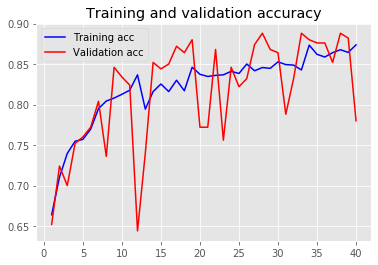

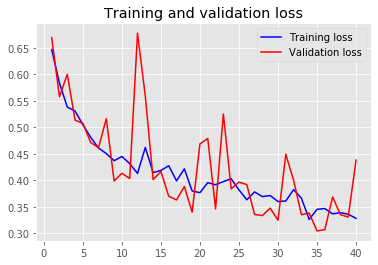

In [87]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()